In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
%matplotlib inline

from datetime import datetime, date, time

# In this notebook, we'll explore the properties of the dataset, see which features have a lot of information, and try to see what feature engineering we can do

In [5]:
train = pd.read_csv('train.csv')

In [6]:
train.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration'],
      dtype='object')

### First look indicates the data set is pretty simple; we've got: 
- times and locations of both pickups and dropoffs (dropoff time will not be provided for test data)
- number of passengers
- vendor/trip ID
- the variable store_and_fwd_flag. Per the dataset description, "This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip"
- The variable to be predicted is trip_duration, which is given in seconds. 
 
Latitude and longitude aren't easy to interpret. Since we're dealing with records for just New York City, we can transform them into cartesian coordinates. To minimize the distortion, let's put the origin at the center of the distribution. Then we can easily calculate the as-the-crow-flies distance traveled as well as the average speed (this can only be done for the training set, but can be used to identify bad data points).

In [44]:
R = 3959   #radius of earth in miles

def sind(x): return np.sin(np.pi * x/180)

def cosd(x): return np.cos(np.pi * x/180)

# This approximation, which assumes the curvature of the earth is zero,
# works as long as we don't have too large of an area. "Too large" means
# a sizeable fraction of the radius of the earth, so even for distances
# of 1,000 miles this should work fine (as long as we're not near a pole)

center_lat = np.mean(train['pickup_latitude'])
center_long = np.mean(train['pickup_longitude'])

train['px'] = R*(train['pickup_longitude'] - center_long)*np.pi/180*cosd(center_lat)
train['py'] = R*(train['pickup_latitude'] - center_lat)*np.pi/180
train['dx'] = R*(train['dropoff_longitude'] - center_long)*np.pi/180*cosd(center_lat)
train['dy'] = R*(train['dropoff_latitude'] - center_lat)*np.pi/180

train['crow_x'] = train['dx'] - train['px']
train['crow_y'] = train['dy'] - train['py']

train['crow_dist'] = np.sqrt((train['crow_x'])**2 + (train['crow_y'])**2)
train['crow_speed'] = train['crow_dist']/train['trip_duration']*3600

Additionally, the date and timestamp need to be parsed. Later we'll add columns with specific parts of the this (eg, hour of day, day of week). But for now we just need something we can search over easily.

In [8]:
def parse_date(datestr):
    return datetime.strptime(datestr, '%Y-%m-%d %H:%M:%S')

train['dt_pickup'] = np.vectorize(parse_date)(train['pickup_datetime'])
train['dt_dropoff'] = np.vectorize(parse_date)(train['dropoff_datetime'])

## Identifying bad data

Now that we have distances and speeds, we can check to see if there are any obviously unreasonable taxi trips in our dataset. Two obvious patterns come to mind: trip with an average speed excessively large, and extremely long trips that go only a short distance. First, let's see how many trips average over 75 mph, and remove them from the dataset

In [9]:
print((train['crow_speed'] >= 75).sum())
outliers_fast = train[train['crow_speed'] >= 75]
train = train[train['crow_speed'] < 75]

136


We can look at the rows we've eliminated. Clearly something went wrong in the data entry process. The store_and_fwd_flag isn't set to Y on many of them, elminating malfunctions with that system as an obvious culprit. 

In [10]:
outliers_fast

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,px,py,dx,dy,crow_dist,crow_speed,dt_pickup,dt_dropoff
1107,id0729156,2,2016-06-23 13:36:48,2016-06-23 13:36:50,3,-73.827660,40.716175,-73.822113,40.711452,N,2,7.633326,-2.400853,7.923662,-2.727173,0.436783,786.210286,2016-06-23 13:36:48,2016-06-23 13:36:50
12527,id0995203,2,2016-05-15 18:31:33,2016-05-15 18:31:59,5,-73.791206,40.666481,-73.800903,40.669819,N,26,9.541478,-5.834593,9.033888,-5.603954,0.557531,77.196587,2016-05-15 18:31:33,2016-05-15 18:31:59
13046,id3468323,1,2016-06-27 18:37:21,2016-06-27 18:43:16,1,-73.881195,40.882942,-73.965141,40.762486,N,355,4.831002,9.122352,0.436821,0.799086,9.411992,95.445554,2016-06-27 18:37:21,2016-06-27 18:43:16
25397,id1957624,2,2016-03-27 16:28:42,2016-03-27 16:32:25,1,-74.069908,40.739052,-74.157913,40.712528,N,223,-5.047219,-0.820125,-9.653861,-2.652841,4.957822,80.036581,2016-03-27 16:28:42,2016-03-27 16:32:25
39020,id2700498,2,2016-01-18 18:19:50,2016-01-18 18:20:06,1,-74.393555,40.785603,-74.398514,40.781822,N,16,-21.988558,2.396419,-22.248143,2.135205,0.368263,82.859089,2016-01-18 18:19:50,2016-01-18 18:20:06
87582,id0508130,2,2016-04-30 00:00:51,2016-04-30 00:01:02,3,-74.000664,40.747410,-74.003189,40.743950,N,11,-1.422609,-0.242608,-1.554798,-0.481681,0.273184,89.405801,2016-04-30 00:00:51,2016-04-30 00:01:02
107171,id1656254,2,2016-01-18 00:35:38,2016-01-18 00:35:54,1,-73.805527,40.651360,-73.804230,40.661629,N,16,8.791875,-6.879449,8.859767,-6.169874,0.712815,160.383378,2016-01-18 00:35:38,2016-01-18 00:35:54
125668,id0456393,1,2016-04-27 06:59:15,2016-04-27 07:03:40,1,-73.979668,40.748005,-73.865097,40.683315,N,265,-0.323564,-0.201488,5.673656,-4.671386,7.479748,101.611676,2016-04-27 06:59:15,2016-04-27 07:03:40
127613,id1322914,2,2016-03-25 17:21:18,2016-03-25 17:21:27,1,-73.801102,40.669941,-73.801392,40.673851,N,9,9.023505,-5.595520,9.008329,-5.325344,0.270602,108.240761,2016-03-25 17:21:18,2016-03-25 17:21:27
133641,id2362780,2,2016-06-30 05:01:03,2016-06-30 05:01:11,1,-74.164268,40.711639,-74.179352,40.711342,N,8,-9.986529,-2.714257,-10.776068,-2.734817,0.789806,355.412911,2016-06-30 05:01:03,2016-06-30 05:01:11


In [11]:
train[train['crow_speed'] < 1].describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,px,py,dx,dy,crow_dist,crow_speed
count,15383.000000,15383.000000,15383.000000,15383.000000,15383.000000,15383.000000,1.538300e+04,15383.000000,15383.000000,15383.000000,15383.000000,15383.000000,15383.000000
mean,1.601183,1.687837,-73.966398,40.746228,-73.966329,40.746446,1.228870e+04,0.371062,-0.324270,0.374647,-0.309172,0.378610,0.209058
std,0.489671,1.356517,0.578113,0.117551,0.578096,0.117702,4.927950e+04,30.261445,8.122514,30.260565,8.132931,1.318125,0.290229
min,1.000000,0.000000,-121.933342,34.359695,-121.933304,34.359695,1.000000e+00,-2510.467566,-441.618246,-2510.465569,-441.618246,0.000000,0.000000
25%,1.000000,1.000000,-73.991154,40.732183,-73.990856,40.731745,8.100000e+01,-0.924804,-1.294713,-0.909229,-1.325025,0.000000,0.000000
50%,2.000000,1.000000,-73.978020,40.752010,-73.977699,40.752232,5.840000e+02,-0.237302,0.075277,-0.220529,0.090565,0.003192,0.052395
75%,2.000000,2.000000,-73.952869,40.767344,-73.952217,40.767544,1.469500e+03,1.079195,1.134763,1.113340,1.148601,0.126313,0.335580
max,2.000000,9.000000,-61.335529,43.911762,-61.335529,43.911762,3.526282e+06,661.536209,218.406503,661.536209,218.406503,17.421785,0.999887


In [12]:
train[train['crow_speed'] < 1].head(10)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,px,py,dx,dy,crow_dist,crow_speed,dt_pickup,dt_dropoff
246,id3487442,2,2016-02-29 18:39:12,2016-02-29 18:42:59,1,-73.981819,40.768963,-73.981819,40.768963,N,227,-0.436184,1.246655,-0.436184,1.246655,0.000000,0.000000,2016-02-29 18:39:12,2016-02-29 18:42:59
251,id0171820,2,2016-05-25 06:40:04,2016-05-25 06:43:13,1,-74.004524,40.724194,-74.004494,40.724667,N,189,-1.624686,-1.846794,-1.623089,-1.814110,0.032724,0.623309,2016-05-25 06:40:04,2016-05-25 06:43:13
291,id0924324,2,2016-05-10 18:07:52,2016-05-10 18:26:21,2,-73.959068,40.775661,-73.959068,40.775661,N,1109,0.754713,1.709513,0.754713,1.709513,0.000000,0.000000,2016-05-10 18:07:52,2016-05-10 18:26:21
323,id2954399,1,2016-06-27 11:22:37,2016-06-27 11:23:17,1,-74.001030,40.756653,-74.000999,40.756626,N,40,-1.441778,0.396062,-1.440181,0.394217,0.002441,0.219649,2016-06-27 11:22:37,2016-06-27 11:23:17
337,id0790613,1,2016-05-20 14:04:03,2016-05-20 14:33:41,1,-73.986305,40.777023,-73.985855,40.776791,N,1778,-0.671009,1.803613,-0.647447,1.787535,0.028526,0.057757,2016-05-20 14:04:03,2016-05-20 14:33:41
407,id1145809,2,2016-05-16 23:15:13,2016-05-16 23:31:00,6,-73.808487,40.687336,-73.808487,40.687336,N,947,8.636923,-4.393566,8.636923,-4.393566,0.000000,0.000000,2016-05-16 23:15:13,2016-05-16 23:31:00
531,id3307903,2,2016-02-20 04:03:06,2016-02-21 03:33:00,3,-74.008102,40.741489,-74.009956,40.714611,N,84594,-1.811987,-0.651694,-1.909032,-2.508923,1.859763,0.079144,2016-02-20 04:03:06,2016-02-21 03:33:00
552,id0131920,2,2016-02-13 17:24:28,2016-02-13 17:56:13,1,-73.996605,40.725510,-73.996239,40.725796,N,1905,-1.210148,-1.755857,-1.190979,-1.736088,0.027537,0.052038,2016-02-13 17:24:28,2016-02-13 17:56:13
702,id3499387,1,2016-01-25 19:45:12,2016-01-25 19:54:52,1,-73.786720,40.647041,-73.786720,40.647041,N,580,9.776303,-7.177829,9.776303,-7.177829,0.000000,0.000000,2016-01-25 19:45:12,2016-01-25 19:54:52
850,id2386155,2,2016-01-24 12:42:54,2016-01-24 12:54:20,1,-73.983528,40.738029,-73.983238,40.737949,N,686,-0.525642,-0.890767,-0.510466,-0.896302,0.016154,0.084772,2016-01-24 12:42:54,2016-01-24 12:54:20


In [13]:
(train['crow_dist'] == 0).sum()

5897

So we have almost 6,000 trips that don't move at all. It's not clear what's happening here -- perhaps a data recording error, or maybe people decide to not take the taxi after getting in. Though it's hard to see how such a non-trip would take over an hour, as we can see happens:

In [14]:
train[train['crow_dist'] == 0].sort_values(by='trip_duration', ascending=False)[:5]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,px,py,dx,dy,crow_dist,crow_speed,dt_pickup,dt_dropoff
168983,id2177467,2,2016-06-05 01:09:39,2016-06-06 01:08:51,1,-73.981407,40.764969,-73.981407,40.764969,N,86352,-0.414619,0.970680,-0.414619,0.970680,0.0,0.0,2016-06-05 01:09:39,2016-06-06 01:08:51
120183,id3070191,2,2016-01-01 15:27:28,2016-01-02 15:09:41,3,-73.989655,40.735657,-73.989655,40.735657,N,85333,-0.846329,-1.054717,-0.846329,-1.054717,0.0,0.0,2016-01-01 15:27:28,2016-01-02 15:09:41
833356,id2761053,2,2016-05-18 13:40:45,2016-05-19 11:25:33,1,-73.971581,40.758572,-73.971581,40.758572,N,78288,0.099759,0.528646,0.099759,0.528646,0.0,0.0,2016-05-18 13:40:45,2016-05-19 11:25:33
607368,id2237791,2,2016-06-08 16:47:44,2016-06-08 18:26:33,1,-73.939049,40.752319,-73.939049,40.752319,N,5929,1.802639,0.096628,1.802639,0.096628,0.0,0.0,2016-06-08 16:47:44,2016-06-08 18:26:33
149352,id1340787,2,2016-05-25 17:36:49,2016-05-25 18:54:52,2,-73.785660,40.651649,-73.785660,40.651649,N,4683,9.831814,-6.859416,9.831814,-6.859416,0.0,0.0,2016-05-25 17:36:49,2016-05-25 18:54:52


We can get rid of these as well, and we'll also get rid of very long slow trips (>1 hr, <1 mph)

In [15]:
zero_dist_trips = train[train['crow_dist']==0]
train = train[train['crow_dist'] > 0]

long_slow_trips = train[train['crow_speed']/train['trip_duration']*3600 < 1]
train = train[train['crow_speed']/train['trip_duration']*3600 >= 1]

In [16]:
train.sort_values(by='trip_duration', ascending=False)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,px,py,dx,dy,crow_dist,crow_speed,dt_pickup,dt_dropoff
114376,id1311087,1,2016-02-29 12:16:29,2016-02-29 18:47:09,3,-75.455917,39.803932,-73.796021,40.707726,N,23440,-77.598129,-65.434634,9.289480,-2.984697,107.002109,16.433771,2016-02-29 12:16:29,2016-02-29 18:47:09
1416336,id3795134,1,2016-03-21 20:54:00,2016-03-22 01:43:23,3,-75.238327,39.923027,-73.922577,40.610130,N,17363,-66.208323,-57.205467,2.664862,-9.728290,83.651646,17.344118,2016-03-21 20:54:00,2016-03-22 01:43:23
31104,id0329738,2,2016-05-11 10:55:24,2016-05-11 14:23:24,1,-73.781219,40.644951,-73.985085,40.762199,N,12480,10.064243,-7.322274,-0.607111,0.779317,13.398267,3.864885,2016-05-11 10:55:24,2016-05-11 14:23:24
1439125,id3886328,1,2016-05-14 15:09:32,2016-05-14 18:20:49,1,-73.791389,40.646168,-73.987968,40.748741,N,11477,9.531893,-7.238190,-0.758070,-0.150616,12.494681,3.919217,2016-05-14 15:09:32,2016-05-14 18:20:49
523766,id1428536,2,2016-06-22 20:55:01,2016-06-23 00:00:00,1,-73.789391,40.647190,-73.972107,40.640392,N,11099,9.636526,-7.167549,0.072203,-7.637260,9.575849,3.105961,2016-06-22 20:55:01,2016-06-23 00:00:00
936006,id2510396,1,2016-01-26 06:58:16,2016-01-26 10:01:01,2,-73.789886,40.646503,-74.458847,40.797791,N,10965,9.610567,-7.214994,-25.406298,3.238577,36.543919,11.998004,2016-01-26 06:58:16,2016-01-26 10:01:01
504829,id1188172,1,2016-01-18 18:21:20,2016-01-18 21:19:44,1,-73.782280,40.644573,-73.991959,40.768063,N,10704,10.008731,-7.348369,-0.966937,1.184449,13.902312,4.675665,2016-01-18 18:21:20,2016-01-18 21:19:44
1424543,id2214754,2,2016-05-15 15:22:02,2016-05-15 18:19:14,1,-73.789452,40.647110,-73.974274,40.748119,N,10632,9.633331,-7.173084,-0.041215,-0.193581,11.929389,4.039296,2016-05-15 15:22:02,2016-05-15 18:19:14
198764,id3773669,2,2016-03-28 17:05:49,2016-03-28 20:02:00,2,-73.989059,40.722076,-73.789932,40.647121,N,10571,-0.815179,-1.993085,9.608171,-7.172293,11.639177,3.963772,2016-03-28 17:05:49,2016-03-28 20:02:00
1074133,id2803246,2,2016-04-27 05:26:46,2016-04-27 08:19:46,4,-73.985817,40.758869,-73.794144,40.656261,N,10380,-0.645450,0.549206,9.387723,-6.540740,12.285435,4.260844,2016-04-27 05:26:46,2016-04-27 08:19:46


Lots of the long trips end at exactly midnight. This is clearly a computer error of some kind. Let's see how many end at exactly midnight, and remove the ones over an hour long (real trips can obviously end at exactly midnight, so we don't want to get rid of all of them)

In [17]:
trips_end_at_midnight_long = train[(train['dt_dropoff'].apply(lambda x: x.time() == time(0,0,0))) & (train['trip_duration'] > 3600)]
train = train[~ train['id'].isin(trips_end_at_midnight_long['id'])]

In [18]:
train.sort_values(by='trip_duration', ascending=False)[['id', 'crow_dist', 'crow_speed', 'trip_duration', 'dt_pickup', 'dt_dropoff']]

,id,crow_dist,crow_speed,trip_duration,dt_pickup,dt_dropoff
114376,id1311087,107.002109,16.433771,23440,2016-02-29 12:16:29,2016-02-29 18:47:09
1416336,id3795134,83.651646,17.344118,17363,2016-03-21 20:54:00,2016-03-22 01:43:23
31104,id0329738,13.398267,3.864885,12480,2016-05-11 10:55:24,2016-05-11 14:23:24
1439125,id3886328,12.494681,3.919217,11477,2016-05-14 15:09:32,2016-05-14 18:20:49
936006,id2510396,36.543919,11.998004,10965,2016-01-26 06:58:16,2016-01-26 10:01:01
504829,id1188172,13.902312,4.675665,10704,2016-01-18 18:21:20,2016-01-18 21:19:44
1424543,id2214754,11.929389,4.039296,10632,2016-05-15 15:22:02,2016-05-15 18:19:14
198764,id3773669,11.639177,3.963772,10571,2016-03-28 17:05:49,2016-03-28 20:02:00
1074133,id2803246,12.285435,4.260844,10380,2016-04-27 05:26:46,2016-04-27 08:19:46
908923,id1115366,8.002600,2.857788,10081,2016-04-19 22:11:02,2016-04-20 00:59:03


# Data Exploration

Now that we've thrown out all of the obvious outliers, it's time to look at the properties and distributions present in the data (thankfully this dataset, provided by Kaggle, has no missing data we have to deal with). Let's start with the most important variable, trip_duration

In [19]:
train['trip_duration'].describe()

count    1.448185e+06
mean     8.364961e+02
std      6.546872e+02
min      1.000000e+00
25%      3.980000e+02
50%      6.620000e+02
75%      1.072000e+03
max      2.344000e+04
Name: trip_duration, dtype: float64

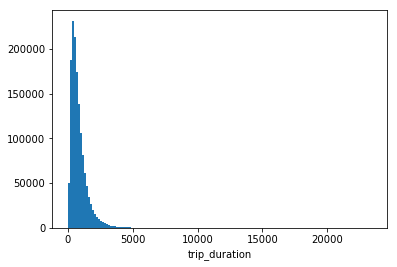

In [20]:
plt.hist(train['trip_duration'], bins=150)
plt.xlabel('trip_duration')
plt.show()

This is clearly not normally distributed. In the contest description (specifically the scoring method), Kaggle gives us a hint that it's log-normally distributed. Let's see what the log10 of the trip duration looks like

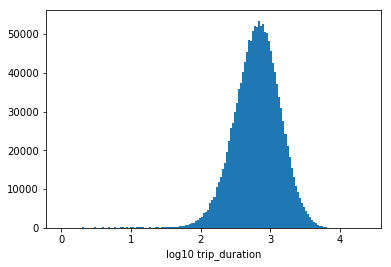

In [29]:
train['log_tripdur'] = np.log10(train['trip_duration'])
plt.hist(train['log_tripdur'], bins=150)
plt.xlabel('log10 trip_duration')
plt.show()

That at least looks Gaussian. To test, we'll turn to scipy.stats

In [30]:
stats.normaltest(train['log_tripdur'])

NormaltestResult(statistic=131772.14598074282, pvalue=0.0)

It's apparently not Gaussian. This test uses skewness and kurtosis; for a gaussian distribution they should be 0 and 3, respectively. Let's see what those values are for this:

In [31]:
print('skewness is: {:.4f}'.format(stats.skew(train['log_tripdur'])))
print('kurtosis is: {:.4f}'.format(stats.kurtosis(train['log_tripdur'])))

skewness is: -0.5501
kurtosis is: 2.0220


The negative skew is evident in the distribution as the longer tail on the left. The low kurtosis means that the tails are smaller than they would be for a gaussian distribution. This may affect the accuracy of the model we build, and is something we should study more.

But now, let's more on to examining the features. First, let's look at the variable store_and_fwd_flag. Let's see how the distribution of trip_duration (we'll always use log10 of trip duration now, unless otherwise stated) varies with the flag. First, the KS test, which reports the maximum difference between the cumulative histograms of the two datasets:

In [37]:
tripdur_store_true = train[train['store_and_fwd_flag']=='Y']['log_tripdur']
tripdur_store_false = train[train['store_and_fwd_flag']=='N']['log_tripdur']

In [38]:
tripdur_store_true.describe()

count    7959.000000
mean        2.886986
std         0.397641
min         0.301030
25%         2.662758
50%         2.912222
75%         3.147367
max         3.999305
Name: log_tripdur, dtype: float64

In [39]:
tripdur_store_false.describe()

count    1.440226e+06
mean     2.805896e+00
std      3.318017e-01
min      0.000000e+00
25%      2.598791e+00
50%      2.820201e+00
75%      3.029789e+00
max      4.369958e+00
Name: log_tripdur, dtype: float64

These look pretty similar, though since only 8,000 out of 1.4 million have the flag active, it probably won't be able to add much to our model. To see if there's any information there at all, let's see if the KS test can differentiate between the two distributions:

In [43]:
stats.ks_2samp(tripdur_store_true, tripdur_store_false)

Ks_2sampResult(statistic=0.12303042729294866, pvalue=8.959181827902058e-105)

So clearly there is a difference. We'll see later if it affects the model.

# Feature Engineering

We've already done a some feature engineering by turning the latitudes/longitudes into cartesian coordinates, finding the distance, and taking the log of the trip duration. But there's more we can do.

The first thing is to remember that taxis don't get to travel as the crow flies. Instead, they're bound to city streets. What we'd really like is to know how far the taxi had to travel, and maybe even which streets it traveled down, but that's for another, much larger project. But because these trips happen in Manhattan, and the streets of Manhattan form a grid, we can get a pretty good approximation of distance traveled. Per [this webpage](http://www.charlespetzold.com/etc/AvenuesOfManhattan/index.html), the streets are about 29 degrees off of a north/south and east/west grid. With that knowledge, we can find the "Manhattan distance", essentially using a rotation matrix.

In [45]:
train['manhattan_x'] = train['crow_x']*cosd(29) - train['crow_y']*sind(29)
train['manhattan_y'] = train['crow_x']*sind(29) + train['crow_y']*cosd(29)

train['manhattan_dist'] = train['manhattan_x'] + train['manhattan_y']

In [46]:
train.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'px', 'py', 'dx', 'dy', 'crow_dist', 'crow_speed',
       'dt_pickup', 'dt_dropoff', 'log_tripdur', 'crow_x', 'crow_y',
       'manhattan_x', 'manhattan_y', 'manhattan_dist'],
      dtype='object')